In this notebook, we're going to train model for classifying BBC article category. [The dataset was downloaded from this page](https://www.kaggle.com/c/learn-ai-bbc/overview).
Some of the code in this notebook were taken from "NLP with TensorFlow" Course in Coursera.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [5]:
# read dataset

with open("/content/drive/MyDrive/Colab Notebooks/Projects/NLP From Zero/BBC News Category - Kaggle/BBC News Train.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

ArticleId,Text,Category

Each data point looks like this:

1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002.

In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/NLP From Zero/BBC News Category - Kaggle/BBC News Train.csv')
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [7]:
df_train['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [8]:
df_train['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [9]:
# encode the Category
df_train.loc[df_train['Category'] == 'sport', 'Label'] = 0
df_train.loc[df_train['Category'] == 'business', 'Label'] = 1
df_train.loc[df_train['Category'] == 'politics', 'Label'] = 2
df_train.loc[df_train['Category'] == 'entertainment', 'Label'] = 3
df_train.loc[df_train['Category'] == 'tech', 'Label'] = 4

labels = tf.keras.utils.to_categorical(df_train['Label'], num_classes=5)
df_train['Label'] = df_train['Label'].astype(int)
df_train.head()

,ArticleId,Text,Category,Label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1
1,154,german business confidence slides german busin...,business,1
2,1101,bbc poll indicates economic gloom citizens in ...,business,1
3,1976,lifestyle governs mobile choice faster bett...,tech,4
4,917,enron bosses in $168m payout eighteen former e...,business,1


In [10]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/NLP From Zero/BBC News Category - Kaggle/BBC News Test.csv')
df_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


### Defining global variables

* NUM_WORDS: The maximum number of words to keep, based on word frequency. Defaults to 1000.
* EMBEDDING_DIM: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.
* MAXLEN: Maximum length of all sequences. Defaults to 120.
* PADDING: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.
* OOV_TOKEN: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "<OOV>".
* TRAINING_SPLIT: Proportion of data used for training. Defaults to 0.8

In [11]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = .8

# PREPROCESSING

In [12]:
# Split the dataset into texts and labels
texts = list(df_train.iloc[:,1]) #second column
labels = list(df_train.iloc[:,3]) #third column

train_size = int(len(df_train['Text']) * training_portion)

# Split texts and labels into training and validation set
training_sentences = texts[:train_size]
training_labels = labels[:train_size]
validation_sentences = texts[train_size:]
validation_labels = labels[train_size:]

# Fit your tokenizer with training data
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Padding sentences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type,
                           padding = padding_type)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length,
                                      truncating = trunc_type, padding = padding_type)

# Convert labels to numpy array
training_labels_finals = np.array(training_labels)
validation_labels_finals = np.array(validation_labels)

In [13]:
training_labels_finals

array([1, 1, 1, ..., 0, 4, 3])

In [14]:
validation_labels_finals

array([3, 3, 2, 1, 4, 1, 3, 0, 0, 0, 1, 4, 1, 3, 4, 2, 0, 2, 2, 4, 3, 0,
       2, 2, 3, 0, 2, 3, 3, 0, 4, 0, 1, 1, 1, 0, 3, 3, 3, 0, 4, 2, 3, 2,
       3, 3, 0, 0, 0, 3, 2, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 2, 1, 3, 1, 1,
       2, 2, 1, 3, 2, 0, 1, 4, 0, 0, 4, 1, 3, 3, 1, 2, 1, 1, 1, 1, 0, 4,
       0, 2, 1, 1, 3, 2, 0, 4, 1, 3, 1, 4, 3, 0, 1, 3, 4, 3, 2, 1, 0, 2,
       4, 0, 2, 4, 1, 2, 4, 1, 3, 4, 1, 0, 3, 0, 4, 4, 0, 4, 4, 2, 2, 0,
       2, 3, 1, 3, 2, 2, 0, 4, 1, 3, 1, 0, 3, 3, 2, 2, 3, 1, 3, 0, 4, 4,
       1, 0, 0, 3, 3, 1, 3, 3, 4, 0, 2, 2, 3, 0, 2, 0, 4, 4, 2, 2, 1, 4,
       1, 1, 4, 4, 0, 1, 1, 3, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 0, 2, 4, 1,
       3, 3, 4, 3, 3, 1, 0, 4, 1, 1, 1, 0, 3, 0, 2, 2, 0, 3, 2, 4, 3, 2,
       3, 0, 3, 2, 2, 1, 4, 3, 0, 3, 2, 2, 1, 3, 2, 1, 0, 2, 3, 1, 2, 3,
       0, 0, 2, 4, 4, 4, 0, 4, 3, 0, 3, 1, 2, 1, 0, 2, 1, 0, 2, 3, 2, 4,
       2, 3, 1, 3, 3, 4, 3, 2, 4, 4, 1, 0, 0, 4, 1, 0, 2, 0, 1, 2, 3, 4,
       2, 1, 1, 0, 4, 3, 1, 3, 3, 1, 4, 4])

# MODELING

In [57]:
# Construct model
model_2 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
        ])

# Model compiling
model_2.compile(
        loss = 'sparse_categorical_crossentropy',
        optimizer = RMSprop(learning_rate=0.001),
        metrics = ['accuracy']
    )

# defining callbacks
callback_list = [
    ModelCheckpoint(
        filepath="model_bbctext_v5.h5",
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weight_only=False,
        verbose=1),

    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode='max',
        baseline=0.5,
        verbose=1,
        restore_best_weights=True),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        mode='min',
        cooldown=1,
        min_lr=0)
    ]

# model training
hist = model_2.fit(
        padded,
        training_labels_finals,
        epochs = 150, #200
        batch_size = 32,
        validation_data = (validation_padded, validation_labels_finals),
        verbose=2,
        steps_per_epoch=8,
        validation_steps=8,
    )

Epoch 1/150
8/8 - 1s - loss: 1.6094 - accuracy: 0.1602 - val_loss: 1.6065 - val_accuracy: 0.2070 - 1s/epoch - 167ms/step
Epoch 2/150
8/8 - 0s - loss: 1.6074 - accuracy: 0.2109 - val_loss: 1.6053 - val_accuracy: 0.2070 - 69ms/epoch - 9ms/step
Epoch 3/150
8/8 - 0s - loss: 1.6052 - accuracy: 0.2227 - val_loss: 1.6057 - val_accuracy: 0.2070 - 71ms/epoch - 9ms/step
Epoch 4/150
8/8 - 0s - loss: 1.6043 - accuracy: 0.2383 - val_loss: 1.6054 - val_accuracy: 0.2070 - 67ms/epoch - 8ms/step
Epoch 5/150
8/8 - 0s - loss: 1.6017 - accuracy: 0.2586 - val_loss: 1.6049 - val_accuracy: 0.2070 - 76ms/epoch - 10ms/step
Epoch 6/150
8/8 - 0s - loss: 1.5873 - accuracy: 0.2852 - val_loss: 1.6043 - val_accuracy: 0.2070 - 72ms/epoch - 9ms/step
Epoch 7/150
8/8 - 0s - loss: 1.6046 - accuracy: 0.2109 - val_loss: 1.6043 - val_accuracy: 0.2070 - 76ms/epoch - 9ms/step
Epoch 8/150
8/8 - 0s - loss: 1.6050 - accuracy: 0.2148 - val_loss: 1.6021 - val_accuracy: 0.2305 - 74ms/epoch - 9ms/step
Epoch 9/150
8/8 - 0s - loss: 1.

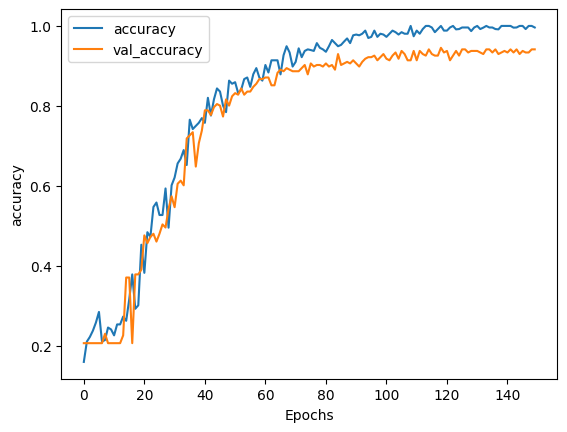

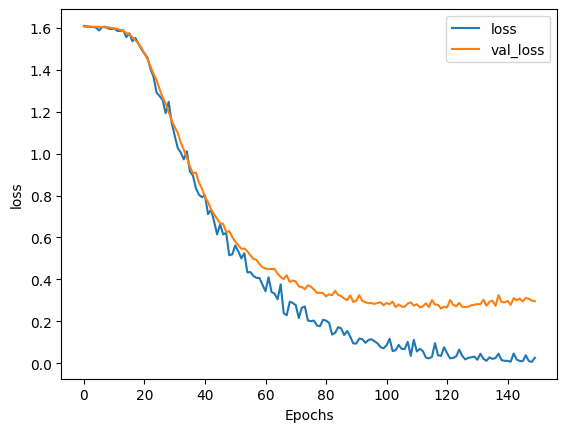

In [58]:
# Plot utility

def plot_graphs(history, string):
  plt.plot(hist.history[string])
  plt.plot(hist.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(hist, "accuracy")
plot_graphs(hist, "loss")

# PREDICTION

In [59]:
# preprocess text in test df
texts_test = list(df_test.iloc[:,1])

# previously, i use new tokenizer here, instead of using tokenizer in the training stage
# i shouldn't do that -_-
# this will lead to poor model perfomance in data test, as you're using different tokenizer

# Padding sentences
sequences = tokenizer.texts_to_sequences(texts_test)
test_padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type,
                    padding = padding_type)

In [60]:
test_padded # check preprocessed result

array([[  1,   1, 245, ...,   1,   4,   1],
       [238,   1, 113, ..., 246,  26,   1],
       [591,   1, 438, ...,   6,   1,   1],
       ...,
       [770,   1, 711, ...,   1,   1,  14],
       [  1,   1,   3, ...,   1,   1,   1],
       [  1, 572,   9, ...,   2, 124, 373]], dtype=int32)

In [61]:
pred_test = model_2.predict(test_padded)
pred_test

23/23 [==============================] - 0s 2ms/step


array([[9.9593580e-01, 1.2342207e-05, 6.8035902e-06, 4.0450613e-03,
        7.6848705e-10],
       [4.6199505e-14, 6.7070992e-05, 9.0738522e-06, 1.2052342e-05,
        9.9991173e-01],
       [9.9999136e-01, 5.4764822e-08, 3.0366220e-07, 8.2732731e-06,
        2.6171029e-14],
       ...,
       [1.5761927e-06, 2.6841059e-02, 1.0879472e-01, 8.5063465e-03,
        8.5585630e-01],
       [1.7280808e-03, 9.9474156e-01, 9.6666976e-04, 2.4359506e-03,
        1.2768689e-04],
       [4.8354227e-06, 3.1169027e-04, 9.9023283e-01, 2.7007930e-04,
        9.1805859e-03]], dtype=float32)

In [62]:
pred_test.shape

(735, 5)

In [63]:
y_pred_classes = np.argmax(pred_test, axis=1) # return class prediction with the highest probability
y_pred_classes

array([0, 4, 0, 1, 0, 0, 2, 0, 3, 1, 1, 4, 3, 4, 3, 0, 2, 4, 3, 3, 1, 2,
       0, 1, 2, 0, 1, 0, 0, 1, 2, 4, 1, 1, 0, 0, 0, 1, 3, 3, 3, 2, 3, 4,
       0, 4, 3, 1, 2, 1, 2, 1, 1, 1, 4, 2, 4, 3, 0, 4, 0, 3, 4, 2, 1, 3,
       3, 4, 0, 0, 1, 0, 1, 2, 4, 0, 4, 4, 4, 3, 2, 0, 3, 0, 0, 3, 1, 3,
       1, 4, 2, 0, 3, 4, 0, 0, 0, 0, 0, 0, 2, 0, 2, 3, 1, 0, 2, 0, 2, 3,
       0, 1, 3, 0, 2, 0, 2, 0, 2, 1, 3, 1, 3, 3, 1, 0, 1, 3, 1, 3, 1, 2,
       2, 4, 1, 1, 0, 4, 3, 0, 1, 4, 0, 3, 2, 0, 0, 3, 3, 4, 1, 4, 2, 3,
       0, 0, 0, 0, 3, 4, 1, 4, 1, 4, 1, 1, 3, 4, 4, 2, 1, 2, 1, 0, 3, 2,
       4, 1, 1, 4, 0, 2, 3, 2, 4, 4, 2, 1, 2, 3, 2, 1, 3, 0, 4, 4, 1, 4,
       2, 1, 0, 2, 1, 3, 1, 1, 0, 4, 2, 0, 3, 4, 0, 3, 2, 4, 2, 3, 0, 3,
       0, 3, 0, 1, 4, 2, 1, 2, 1, 4, 1, 0, 2, 2, 2, 0, 0, 1, 4, 2, 0, 2,
       1, 0, 4, 1, 2, 1, 2, 1, 1, 0, 4, 2, 3, 4, 3, 4, 0, 0, 4, 0, 0, 0,
       3, 0, 2, 3, 3, 0, 1, 0, 1, 0, 3, 1, 1, 3, 2, 1, 0, 0, 4, 0, 0, 3,
       1, 0, 4, 2, 3, 1, 1, 2, 0, 3, 0, 1, 0, 0, 4,

# Submission

In [64]:
df_test['Label'] = pd.DataFrame(y_pred_classes)
df_test.head() # for now, please ignore the 'Category' column

,ArticleId,Text,Label,Category
0,1018,qpr keeper day heads for preston queens park r...,0,business
1,1319,software watching while you work software that...,4,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,0,sport
3,459,india s reliance family feud heats up the ongo...,1,business
4,1020,boro suffer morrison injury blow middlesbrough...,0,sport


In [49]:
df_test['Label'].value_counts()

1    195
0    159
2    139
4    133
3    109
Name: Label, dtype: int64

In [65]:
# decode back, using the exact same order like we use in df_train

def label_to_category(label):
    if label == 0:
        return 'sport'
    elif label == 1:
        return 'business'
    elif label == 2:
        return 'politics'
    elif label == 3:
        return 'entertainment'
    else:
        return 'tech'

In [66]:
df_test['Category'] = df_test['Label'].apply(label_to_category)
df_test.head()

,ArticleId,Text,Label,Category
0,1018,qpr keeper day heads for preston queens park r...,0,sport
1,1319,software watching while you work software that...,4,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,0,sport
3,459,india s reliance family feud heats up the ongo...,1,business
4,1020,boro suffer morrison injury blow middlesbrough...,0,sport


In [67]:
texts_id = df_test.iloc[:,0]
pred_cat = df_test.iloc[:,3]

submission = pd.DataFrame(list(zip(texts_id, pred_cat)),
               columns =['ArticleId', 'Category'])
submission.head(20)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,sport
8,27,entertainment
9,397,business


In [68]:
submission.to_csv('submission_2_dense.csv', index=False)